# Cell Segmentation Analysis
This notebook provides an introduction to using various image processing techniques for cell segmentation analysis.
The steps involve preprocessing, noise reduction, segmentation, and visualization. This guide will walk you through each component to help you understand and apply the analysis.

### Dependencies:
- `numpy` for numerical operations
- `napari` for image visualization
- `skimage` for image processing functions
- `matplotlib` for plotting
- `tqdm` to visualize loop progress
- `TCFile` to import .TCF file
- etc.

Let's get started!

In [ ]:
from TCFile import TCFile
import numpy as np
import napari
import h5py
from skimage import morphology, filters, feature, measure, restoration, segmentation
from tqdm import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy import ndimage

def circular_filter(array_shape, pixel_radius):
    filter = np.zeros(array_shape)
    N = array_shape[0]
    x, y = np.arange(N), np.arange(N)
    X, Y = np.meshgrid(x, y)
    filter[(X-N//2)**2 + (Y-N//2)**2 < pixel_radius**2] = 1
    return filter

def fourier_filter_with_thresholding(image, threshold, filter):

    temp = np.zeros(image.shape)
    temp = temp + image
    temp[image<threshold] = 0
    ###############################
    temp = filters.gaussian(temp)

    a_fourier = np.fft.fftshift(np.fft.fft2(temp))
    H, W = a_fourier.shape
    a_fourier[H//2:H//2 + 1, W//2:W//2 + 1]=0
    a_fourier = a_fourier * filter
    a_mod = np.fft.ifft2(a_fourier)
    ################################
    return np.abs(a_mod)

def get_mip_with_noise_reduction(data, first_thr_idx=0, second_thr_idx=1, fourier_filter_radius=400):
    # Get MIP image
    img_max = np.max(data, axis=0)
    #######################################################
    # Noise reduction
    thr = filters.threshold_multiotsu(img_max, 4)
    aa = fourier_filter_with_thresholding(img_max, thr[first_thr_idx], fourier_filter_radius)
    # Thresholding for better clarity
    aa_thr = filters.threshold_multiotsu(aa)
    aa[aa<aa_thr[second_thr_idx]] = 0
    # Mask generating and applying remove small objects
    mask = aa.copy()
    mask = morphology.remove_small_objects(mask.astype(bool), 500)
    aa[mask==0] = 0
    # mask initialization for memory
    mask = 0
    #######################################################
    return aa

In [3]:
viewer = napari.Viewer()

<h1> Try : MIP time label </h1>

### This code processes a 3D dataset to extract bounding box or cylindrical regions from maximum intensity projection (MIP) images. It utilizes Fourier filtering and edge detection to highlight key features within each slice of the dataset. This approach can help identify and isolate significant regions within a 3D stack for further analysis, such as bounding regions of interest or calculating specific structural areas.

In [4]:
dir = r"C:\rkka_Projects\cell_death_v1\Data\pathway\raw\Apoptosis/"
file = "compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P29.TCF"

tcfile = TCFile(dir + file, '3D')

### tcfile[i] is i_th timestep of tcffile

In [5]:
N = tcfile[0][0].shape[0]
Z = tcfile[0].shape[0]

In [6]:
data_stack = np.zeros((36, N, N))
filtered_data_stack = np.zeros((36, N, N))
sobel = np.zeros((36, N, N))
filter = circular_filter((1009,1009), 400)
for i in tqdm(range(36)):
    data_stack[i] = np.max(tcfile[i], axis=0)
    filtered_data_stack[i] = fourier_filter_with_thresholding(data_stack[i], 0, filter)
    sobel[i] = filters.sobel(filtered_data_stack[i])
viewer.add_image(data_stack)
viewer.add_image(filtered_data_stack)
viewer.add_image(sobel)

100%|██████████| 36/36 [00:32<00:00,  1.10it/s]


<Image layer 'sobel' at 0x23eb5054410>

### Using gaissian filter can improve performance of sobel filter, because the sobel filter is sensitive to noise artifacts

In [57]:
temp = filtered_data_stack.copy()
for i in range(36):
    temp[i] = filters.gaussian(temp[i])
    temp[i] = filters.gaussian(temp[i])
    temp[i] = filters.gaussian(temp[i])
viewer.add_image(temp)

<Image layer 'temp [1]' at 0x2848aa2e070>

In [58]:
viewer.add_image(filters.sobel(temp))

<Image layer 'Image' at 0x28719377b20>

### This code processes 3D microscopy images of cells, specifically for necroptosis studies, using time-labeled masks to extract regions of interest. For each image in the dataset, it uses bounding boxes defined by these masks to crop relevant cell regions, saving them in an HDF5 format with time-stamped labels. This workflow assists in organizing and analyzing data over time for specific cell areas.

In [18]:
dir = "C:/rkka_Projects/Cell/Data/Apoptosis/"
file = "compressed_230512.160429.CD95_TNF_Ctr.003.CD95.A1.T001P12.TCF"

tcfile = TCFile(dir + file, '3D')
N = tcfile[0][0].shape[0]
Z = tcfile[0].shape[0]

In [ ]:
from tifffile import imread  # Import the function to read TIFF files

# Directory containing necroptosis image data
necropto_dir = "C:/rkka_Projects/Cell/Data/Necroptosis/"

# List of 3D image files for necroptosis samples
necropto_file_list = [
    'compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.TCF',
    'compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.TCF',
    # ... (more files in the list)
]

# Corresponding masks for each necroptosis sample, to be used for bounding boxes
necropto_mask_list = [
    'boxmask_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.tif',
    'boxmask_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.tif',
    # ... (more mask files in the list)
]

# Organizing directory, file, and mask lists
dir_list = [necropto_dir]
file_file_list = [necropto_file_list]
mask_file_list = [necropto_mask_list]
time_range = 36  # Define the number of time points to process

# Main processing loop for each directory
for dir in dir_list:
    for f in range(len(file_file_list)):  # Iterate over file and mask lists
        file_list = file_file_list[f]
        mask_list = mask_file_list[f]
        
        # Loop through each file and its corresponding mask
        for ff in range(len(file_list)):
            file = file_list[ff]     # Current image file
            mask = mask_list[ff]     # Corresponding mask file
            
            # Load the 3D cell data
            tcfile = TCFile(dir + file, '3D')
            N = tcfile[0][0].shape[0]  # Get dimensions of each 2D slice (height/width)
            Z = tcfile[0].shape[0]     # Number of slices in the 3D stack
            
            # Load the mask file as a binary label image
            time_label = imread(dir + mask)
            # Remove small, irrelevant objects from the mask for cleaner labeling
            time_label = morphology.remove_small_objects(time_label, min_size=1400)
            # Get properties of labeled regions, including area and bounding box
            time_label_props = pd.DataFrame(measure.regionprops_table(
                time_label, properties=['label', 'area', 'bbox']
            ))
            label_list = list(time_label_props['label'])  # List of unique labels in the mask
            
            # Initialize list to store bounding box coordinates
            bbox_list = []
            for i in range(time_label_props.shape[0]):
                s = time_label_props.iloc[i]
                # Define bounding box coordinates as [min_row, min_col, max_row, max_col]
                b = [int(s['bbox-1']), int(s['bbox-2']), int(s['bbox-4']), int(s['bbox-5'])]
                bbox_list.append(b)

            # Create HDF5 file to store cropped regions by bounding box and time
            with h5py.File(dir + 'sam_manual_mlp_boxed_' + file + '.h5', 'w') as f:
                # Loop through each time point in the dataset
                for t_idx in tqdm(range(time_range), desc='Box Making Iter'):
                    # Get the mask slice for the current time point
                    time_label_slice = time_label[t_idx]
                    # Stack the 2D mask to match the 3D data shape for the current time point
                    time_label_stacked = np.stack((time_label_slice,) * Z, axis=0)
                    # Load the 3D image data for the current time point
                    img = tcfile[t_idx]
                    # Normalize the image intensity range to [1.3, 1.4]
                    img = 1.3 + 0.1 * (img - img.min()) / (img.max() - img.min())
                    
                    # Loop through each bounding box, cropping and saving the data
                    for b_idx, bbox in enumerate(bbox_list):
                        temp = img.copy()  # Copy image to avoid overwriting
                        # Set pixels outside the current bounding box to 1.3
                        temp[time_label_stacked != label_list[b_idx]] = 1.3
                        # Save the cropped image region in HDF5 format
                        f.create_dataset(
                            'box/' + str(b_idx).zfill(3) + '/time/' + str(t_idx * 0.5).zfill(4),
                            data=temp[:, bbox[0]:bbox[2], bbox[1]:bbox[3]]
                        )
                        # Save the label metadata if processing the first time point
                        if t_idx == 0:
                            f.create_dataset('box/' + str(b_idx).zfill(3) + '/label', data=label_list[b_idx])
                f.close()  # Close the HDF5 file
            print('file ended')  # Print notification when processing is complete


Box Making Iter: 100%|██████████| 36/36 [01:50<00:00,  3.07s/it]


file ended


Box Making Iter: 100%|██████████| 36/36 [02:17<00:00,  3.81s/it]


file ended


Box Making Iter: 100%|██████████| 36/36 [01:45<00:00,  2.93s/it]


file ended


Box Making Iter: 100%|██████████| 36/36 [01:23<00:00,  2.33s/it]


file ended


Box Making Iter: 100%|██████████| 36/36 [02:32<00:00,  4.24s/it]


file ended


Box Making Iter: 100%|██████████| 36/36 [02:03<00:00,  3.42s/it]


file ended


Box Making Iter: 100%|██████████| 36/36 [01:58<00:00,  3.28s/it]

file ended


In [ ]:
# Initialize an empty list to store bounding box coordinates for each region
bbox_list = []

# Loop through each row in `time_label_props`, which contains properties for labeled regions
for i in range(time_label_props.shape[0]):
    s = time_label_props.iloc[i]  # Get the properties for the current region (row)
    
    # Extract the bounding box coordinates: min row, min col, max row, max col
    # These coordinates define the rectangular area that contains the labeled region
    b = [int(s['bbox-1']), int(s['bbox-2']), int(s['bbox-4']), int(s['bbox-5'])]
    
    # Append the bounding box coordinates to `bbox_list`
    bbox_list.append(b)

# `bbox_list` now contains the bounding box coordinates for each region, formatted as:
# [[min_row, min_col, max_row, max_col] for each region]
bbox_list  # Display the list of bounding boxes


[[0, 387, 282, 588],
 [79, 690, 488, 996],
 [131, 298, 680, 739],
 [354, 0, 576, 339],
 [352, 717, 834, 1009],
 [421, 128, 825, 407],
 [517, 0, 1009, 231]]

In [ ]:
# Define the time range (number of time points) for 3D time label processing
time_range = 36

# Open an HDF5 file to store processed images, creating a new file in write mode
with h5py.File(dir + 'sam_manual_mlp_boxed_' + file + '.h5', 'w') as f:
    
    # Loop over each time point in the time range
    for t_idx in tqdm(range(time_range), desc='Box Making Iter'):
        
        # Get the label mask slice for the current time point
        time_label_slice = time_label[t_idx]
        
        # Stack the 2D mask slice along the Z-axis to match the shape of the 3D image
        time_label_stacked = np.stack((time_label_slice,) * Z, axis=0)
        
        # Load the 3D image data for the current time point
        img = tcfile[t_idx]
        
        # Normalize the image intensity range to [1.3, 1.4], where 1.3 is the minimum data value
        # This normalization brings values within a consistent range for easier visualization or processing
        img = 1.3 + 0.1 * (img - img.min()) / (img.max() - img.min())
        
        # Loop over each bounding box region identified in the mask
        for b_idx, bbox in enumerate(bbox_list):
            print(b_idx)  # Print the index of the current bounding box
            
            # Create a copy of the normalized image to modify within the bounding box
            temp = img.copy()
            
            # Set all pixels outside the current label region (bounding box) to the minimum value, 1.3
            # This isolates the region of interest by making everything else the background
            temp[time_label_stacked != label_list[b_idx]] = 1.3
            
            # Save the cropped 3D region within the bounding box to the HDF5 file
            # The dataset is saved with a hierarchical naming structure: `box/###/time/####`
            # where ### is the zero-padded bounding box index, and #### is the time label
            f.create_dataset(
                'box/' + str(b_idx).zfill(3) + '/time/' + str(t_idx * 0.5).zfill(4),
                data=temp[:, bbox[0]:bbox[2], bbox[1]:bbox[3]]
            )
            
            # On the first time point only, save the label metadata for each bounding box
            if t_idx == 0:
                f.create_dataset('box/' + str(b_idx).zfill(3) + '/label', data=label_list[b_idx])

# The HDF5 file is automatically closed when exiting the `with` block

<h3> Connection based labeling </h3>

In [76]:
dir = "C:/rkka_Projects/Cell/Data/Necroptosis/"
file = "compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P03.TCF"

tcfile = TCFile(dir + file, '3D')

In [ ]:
# Initialize an empty list to store distance maps for each time point
dmaps = []

# Variables to store base properties of the labeled regions in the first time point
base_prop = None
base_label_num = 0

# Initialize a data stack to hold 2D Maximum Intensity Projection (MIP) images for 36 time points
data_stack = np.zeros((36, 1009, 1009))

# Loop over each time point in the dataset (36 in total)
for i in tqdm(range(36)):
    # Step 1: Load and preprocess the image for segmentation
    img = tcfile[i]  # Load the 3D image at the current time point
    img_max = np.max(img, axis=0)  # Compute the MIP to get a 2D projection of the 3D image
    # Apply noise reduction and thresholding to clean up the MIP
    aa = get_mip_with_noise_reduction(img, first_thr_idx=0, second_thr_idx=1)
    img_max[aa == 0] = 0  # Mask out background regions in the MIP based on noise reduction results
    data_stack[i] = img_max  # Store the processed MIP in the data stack
    
    # Step 2: Generate a distance map for the segmented regions
    # Calculate the Euclidean distance transform on the segmented MIP
    distance_map = ndimage.distance_transform_edt(img_max)

    # Apply multi-Otsu thresholding to segment the distance map into regions
    thr = filters.threshold_multiotsu(distance_map, 4)
    # Set all values below the first threshold to 0, focusing on higher-intensity regions
    distance_map[distance_map < thr[0]] = 0
    # Remove small objects from the distance map for cleaner segmentation
    distance_map = morphology.remove_small_objects(distance_map.astype(bool), 1000)

    # Append the processed distance map to `dmaps` for this time point
    dmaps.append(distance_map)

    # For the first time point, label the regions and calculate properties for future reference
    if i == 0:
        label = measure.label(distance_map)  # Label connected components in the distance map
        # Extract properties of labeled regions, such as area, and store in `base_prop`
        base_prop = measure.regionprops_table(label, properties=['label', 'area'])
        # Store the number of labeled regions for comparison with later time points
        base_label_num = len(base_prop['label'])
    else:
        pass  # No further labeling or property extraction for subsequent time points

100%|██████████| 36/36 [00:36<00:00,  1.01s/it]


In [ ]:
# Make a stack to get timelapsed MIP data. In this case 0th dimension becomes time axis.
stack = np.zeros((len(dmaps), dmaps[0].shape[0], dmaps[0].shape[1]))
for d in range(len(dmaps)):
    stack[d] = dmaps[d]

In [82]:
viewer.add_image(data_stack)

<Image layer 'data_stack' at 0x284946f0550>

In [ ]:
# Initialize a 3D array to store distance maps for each time point
# Shape: (number of time points, height, width)
stack = np.zeros((len(dmaps), dmaps[0].shape[0], dmaps[0].shape[1]))

# Populate `stack` with the distance maps from `dmaps`
for d in range(len(dmaps)):
    stack[d] = dmaps[d]  # Assign each 2D distance map to the corresponding slice in `stack`

# Label connected regions across the 3D `stack` to identify distinct regions in time and space
stack_label = measure.label(stack)

# Extract properties of each labeled region using `regionprops_table`
# Properties extracted: label identifier and area (pixel count)
props = measure.regionprops_table(stack_label, properties=['label', 'area'])

# Convert extracted properties to a DataFrame and sort by area in descending order
df = pd.DataFrame(props).sort_values(by='area', ascending=False).reset_index(drop=True)

# Calculate the number of unique time points (or "connected layers") each region spans
# For each label, find the unique time layers it appears in and count them
df['connected_layers_num'] = df['label'].apply(
    lambda lbl: len(np.unique(np.where(stack_label == lbl)[0]))
)

# Filter out regions where 'connected_layers_num' is less than the total number of time points
# This step removes regions that appear in fewer than 5 layers, typically artifacts
remove_df = df[df['connected_layers_num'] < stack.shape[0]]
remove_list = list(remove_df['label'])  # List of labels to be removed due to insufficient layers

# Remove identified regions from `stack_label` by setting their values to 0
for rlabel in remove_list:
    stack_label[stack_label == rlabel] = 0

# Re-label the `stack_label` after removing regions to ensure continuity in labeling
stack_label = measure.label(stack_label)

In [ ]:
# Retry with another approach
temp = data_stack.copy()
for i in range(36):
    temp[i] = ndimage.distance_transform_edt(temp[i])
    thr = filters.threshold_multiotsu(temp[i], 4)
    temp[i][temp[i]<thr[1]] = 0
viewer.add_image(temp)

<Image layer 'temp' at 0x28498968be0>

In [129]:
temp_labels = measure.label(temp.astype(bool))

In [153]:
viewer.add_labels(temp_labels)

<Labels layer 'temp_labels' at 0x28498a00850>

In [134]:
props = measure.regionprops_table(temp_labels, properties=['label', 'bbox'])
props = pd.DataFrame(props)
props

,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,1,0,0,648,36,133,971
1,2,0,117,420,36,296,726
2,3,0,312,763,36,603,949
3,4,0,256,98,36,477,273
4,5,0,276,296,36,584,482
...,...,...,...,...,...,...,...
63,64,30,649,543,36,673,562
64,65,33,672,676,34,673,678
65,66,34,410,642,35,411,643
66,67,34,411,644,35,413,646


In [138]:
props = props.drop(index=props[props['bbox-0']!=0].index)
props = props.drop(index=props[props['bbox-3']!=36].index)
props

,label,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,1,0,0,648,36,133,971
1,2,0,117,420,36,296,726
2,3,0,312,763,36,603,949
3,4,0,256,98,36,477,273
4,5,0,276,296,36,584,482
5,6,0,330,513,36,484,780
6,7,0,566,165,36,738,361
7,8,0,541,609,36,773,874
9,10,0,722,303,36,1009,665


In [144]:
props.iloc[0]['label']

1

In [160]:
viewer.add_image(temp_labels==props.iloc[3]['label'])

<Image layer 'Image' at 0x28535728f10>

In [162]:
z = np.zeros((36, 1009, 1009))
for i in range(props.shape[0]):
    z = z + (temp_labels==props.iloc[i]['label']).astype(int)


In [164]:
viewer.add_image(z)

<Image layer 'z' at 0x2853868dfd0>

In [117]:
# Label the stack
stack_label = measure.label(temp.astype(bool))

# Extract properties using regionprops_table
props = measure.regionprops_table(stack_label, properties=['label', 'area'])

# Convert the properties to a DataFrame and sort by 'area'
df = pd.DataFrame(props).sort_values(by='area', ascending=False).reset_index(drop=True)

# Calculate the number of connected layers for each region and store in a new column
df['connected_layers_num'] = df['label'].apply(lambda lbl: len(np.unique(np.where(stack_label == lbl)[0])))

# Filter out rows where 'connected_layers_num' is less than 5
remove_df = df[df['connected_layers_num'] < stack.shape[0]]
remove_list = list(remove_df['label'])
for rlabel in remove_list:
    stack_label[stack_label == rlabel] = 0

stack_label = measure.label(stack_label)


In [118]:
viewer.add_labels(stack_label)

<Labels layer 'stack_label' at 0x287c8951bb0>

<h1> Label Manual 보정 </h1>

In [46]:
N = tcfile[0][0].shape[0]
data_stack = np.zeros((36, N, N))
for i in tqdm(range(36)):
    data_stack[i] = np.max(tcfile[i], axis=0)

viewer.add_image(data_stack)

<Image layer 'data_stack' at 0x2001d64d820>

<h3> Cell 경계 manually 삭제 </h3>

In [49]:
cut_stack = viewer.layers['Labels'].data
stack_label[cut_stack!=0] = 0
viewer.add_image(stack_label)

<Image layer 'stack_label [1]' at 0x1fff5157970>

Creating SAM image embedding: 100%|██████████| 36/36 [00:13<00:00,  2.73it/s]
c:\miniconda3\envs\lab\lib\site-packages\napari_sam\_widget.py:918: UserWarning: There is already a point in this location. This click will be ignored.
  warnings.warn("There is already a point in this location. This click will be ignored.")


<h3> 이후 SAM & 저장 </h3>

In [50]:
final_label = viewer.layers['Labels'].data
viewer.add_image(final_label)

<Image layer 'final_label' at 0x2021eb66640>

In [51]:
# 잘됐는지 check
pd.DataFrame(measure.regionprops_table(final_label, properties=['label', 'area', 'bbox']))

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,1,436606.0,0,72,233,36,272,609
1,2,384770.0,0,0,426,36,377,830
2,3,208422.0,0,76,665,36,348,855
3,4,208879.0,0,263,42,36,543,228


Creating SAM image embedding: 100%|██████████| 36/36 [00:13<00:00,  2.73it/s]


In [36]:
final_label = viewer.layers['Labels'].data

with h5py.File(dir + 'sam_boxinfo_' + file + '.h5', 'w') as f:
    f.create_dataset('labels', data = final_label)
    f.close()

<h3> 불러오기 </h3>

In [39]:
sam_labels = h5py.File(dir + 'sam_boxinfo_' + file + '.h5')
sam_labels = np.array(sam_labels['labels'])
sam_props = pd.DataFrame(measure.regionprops_table(sam_labels, properties=['label', 'area', 'bbox']))
sam_props

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5
0,1,379236.0,0,0,633,36,162,993
1,2,438569.0,0,81,377,36,311,764
2,3,423918.0,0,240,85,36,500,286
3,4,441946.0,0,321,265,36,595,496
4,5,499877.0,0,306,462,36,498,797
5,6,360715.0,0,297,745,36,786,967
6,7,365727.0,0,544,124,36,752,376
7,9,370639.0,0,609,343,36,976,684
8,10,499584.0,0,506,576,36,814,908
9,11,529954.0,0,674,288,36,1009,713


In [40]:
bbox_list = []
for i in range(sam_props.shape[0]):
    s = sam_props.iloc[i]
    # min row, min col, max row, max col
    b = [int(s['bbox-1']), int(s['bbox-2']), int(s['bbox-4']), int(s['bbox-5'])]
    bbox_list.append(b)

<h3> Box 따라서 저장 </h3>

In [42]:
#####
time_range = 36

with h5py.File(dir + 'timelapsed_mlp_boxed_' + file + '.h5', 'w') as f:
    for t_idx in tqdm(range(time_range), desc='Box Making Iter'):
        img = tcfile[t_idx]
        for b_idx, bbox in enumerate(bbox_list):
            f.create_dataset('box/' + str(b_idx).zfill(3) + '/time/' + str(t_idx*0.5).zfill(4), data = img[:, bbox[0]:bbox[2], bbox[1]:bbox[3]])
    f.close()

Box Making Iter: 100%|██████████| 36/36 [00:39<00:00,  1.10s/it]


<h3> 경계 등분하는 알고리즘 </h3>

In [ ]:
def separate_distance_map_with_centroids(distance_map, centroid1, centroid2):
    
    points_idx = np.array(np.where(distance_map!=0))
    
    # Calculate vector, midpoint, and perpendicular vector
    vector = centroid2 - centroid1
    midpoint = (centroid1 + centroid2) / 2

    def classify_point(point, midpoint, vector):
        relative_position = point - midpoint
        dot_product = np.dot(relative_position, vector)
        return 'left' if dot_product > 0 else 'right'

    classified_points = {'left': [], 'right': []}

    for p_idx in range(points_idx.shape[1]):
        point = np.array([points_idx[0][p_idx], points_idx[1][p_idx]])
        side = classify_point(point, midpoint, vector)
        classified_points[side].append(point)

    # Convert classified points to numpy arrays for plotting
    classified_points['left'] = np.array(classified_points['left'])
    classified_points['right'] = np.array(classified_points['right'])
    
    separated_distance_map = np.zeros(distance_image.shape)
    for l in classified_points['left']:
        separated_distance_map[l[0], l[1]] = 1

    for r in classified_points['right']:
        separated_distance_map[r[0], r[1]] = 2
        
    return separated_distance_map

Text(0.5, 1.0, 'Separated distance map')

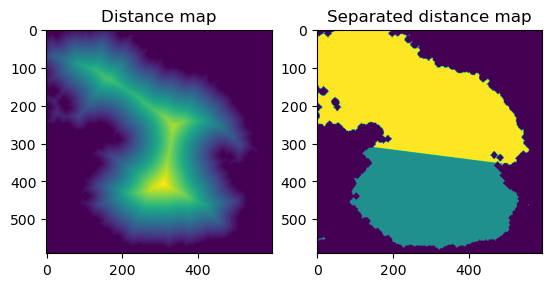

In [137]:
from PIL import Image
points = Image.open('ttt.png').convert('L')
points = np.array(points)
fig, axes = plt.subplots(1,2)
axes[0].imshow(points)
axes[0].set_title('Distance map')
axes[1].imshow(separate_distance_map_with_centroids(points, np.array([255,333]), np.array([411,313])))
axes[1].set_title('Separated distance map')

In [177]:
import h5py
import numpy
import napari
import pandas as pd

dir = "C:/rkka_Projects/Cell/Data/Necroptosis/"
file = 'mlp_boxed_compressed_230510.174730.HeLa_Hoechst.001.Group1.A2.T001P02.TCF.h5'

In [178]:
a = h5py.File(dir+file)

In [179]:
a['box'].keys()

<KeysViewHDF5 ['000', '001', '002', '003', '004', '005', '006']>

In [184]:
viewer = napari.Viewer()

In [187]:
box = np.array(a['box/002/time/10.0'])
box[box<1.327]=0
viewer.add_image(box)

<Image layer 'box [1]' at 0x23c10494e80>